# Clasificación con redes neuronales convolucionales


In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import os
import sys

sys.path.append(os.path.dirname(os.path.abspath(os.path.abspath(""))))

# Resolviendo un problema de clasificacion

A lo largo de esta sección repasaremos los conceptos de CNNs aprendidos hasta el momento, creando una red neuronal capas de clasificar entre 10 diferentes tipos de clases. Para ello vamos a utilizar el dataset [CIFAR10](https://keras.io/api/datasets/cifar10/) el cual consta de 50,000 imágenes de 32x32 píxeles a color, para el training set y 10,000 imágenes con las mismas características para el conjunto de pruebas.

Las clases disponibles son:

| Label |  Description   |
| :---: | :------------: |
|   0   |  **Airplane**  |
|   1   | **Automobile** |
|   2   |    **Bird**    |
|   3   |    **Cat**     |
|   4   |    **Deer**    |
|   5   |    **Dog**     |
|   6   |    **Frog**    |
|   7   |   **Horse**    |
|   8   |    **Ship**    |
|   9   |   **Truck**    |


## importamos bibliotecas necesarias:


In [4]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import matplotlib.pyplot as plt
import numpy as np
from keras import regularizers
from keras.datasets import cifar10
from keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.models import Sequential
from keras.utils import to_categorical

Definimos nuestra función auxiliar para gráficar resultados:


In [6]:
def plot_result(history_, metric):
    history_dict = history_.history
    loss_values = history_dict["loss"]
    val_loss_values = history_dict["val_loss"]
    metric_values = history_dict[metric]
    val_metric_values = history_dict[f"val_{metric}"]
    epoch = range(1, len(loss_values) + 1)

    fig, ax = plt.subplots(1, 2, figsize=(8, 5))

    fig.suptitle(f"Neural Network's Result")
    ax[0].set_title("Loss function over epochs")
    ax[0].set(ylabel="Loss", xlabel="Epochs")
    ax[0].plot(epoch, loss_values, "o-r", label="Training")
    ax[0].plot(epoch, val_loss_values, "--", label="Validation")
    ax[0].legend()

    ax[1].set_title(f"{metric} over epochs")
    ax[1].set(ylabel=metric, xlabel="Epochs")
    ax[1].plot(epoch, metric_values, "o-r", label="Training")
    ax[1].plot(epoch, val_metric_values, "--", label="Validation")
    ax[1].legend()

    plt.show()

## Descargamos el dataset CIFAR10


In [7]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 18s 0us/step


In [8]:
print(f"x_train shape: {X_train.shape}")

x_train shape: (50000, 32, 32, 3)


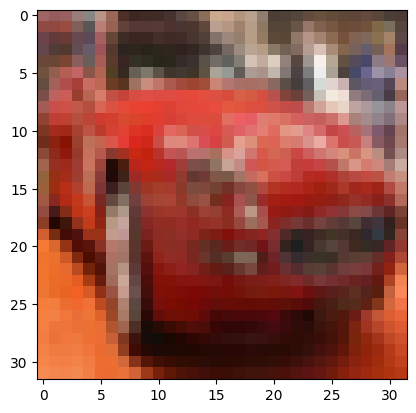

In [12]:
plt.imshow(X_train[5])

## 3: Limpiamos nuestros datos

Como ya sabemos, lo primero que debemos hacer es normalizar la escala de nuestros pixeles de 0-255 a 0-1


In [13]:
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

También sabemos que aunque NO es la única forma de trabajar para clasificación de multiples clases, es una estrategia convertir el label encoding en one hot encoding:


In [14]:
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

## 4: Creando particiones de validación


In [16]:
# Creando nuevas particiones de los datos

(X_train, X_valid) = X_train[5000:], X_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

print(f"x_train shape: {X_train.shape}")
print(f"{X_train.shape[0]} train samples\n")

print("train: ", X_train.shape[0])
print("val: ", X_valid.shape[0])
print("test: ", X_test.shape[0])

x_train shape: (40000, 32, 32, 3)
40000 train samples

train:  40000
val:  5000
test:  10000


Podemos observar como ahora contamos con 3 conjuntos de datos, para el set de entrenamiento tenemos 45,000 muestras, de las cuales cada una de ellas tiene una forma de `(32, 32, 3)`. Para el conjunto de validación tenemos **5,000 muestras**y para el conjunto de pruebas **10,000.**


## Creación de red convolucional para clasificación


### Definiendo la arquitectura del modelo

Para este paso es importante recordar:

- Debemos tener presente el shape de las imágenes del dataset.

- La cantidad de filtros aplicados en cada capa es arbitrario, pero generalmente conforme más profunda es la capa mayor cantidad de filtros

- La capa de `MaxPooling2D` sirve para reducir la complejidad del modelo, al ir reduciendo las dimensiones de la capa.

- Utilizar una capa de `DropOut` es una buena idea para reducir el posible overfitting que puede presentar el modelo.

- La arquitectura propuesta a continuación NO es una receta de cocina y NO tiene por qué ser la mejor para todos los escenarios, es simplemente una propuesta que sigue la arquitectura básica de cualquier CNN vista en [Arquitectura de una CNN](https://github.com/ichcanziho/Deep_Learnining_Platzi/tree/master/2%20Curso%20de%20Redes%20Neuronales%20Convolucionales)


In [23]:
def architecture(
    base_filtros: int, w_regularized: float, shape: tuple, num_classes: int
):
    """
    Definiendo la arquitectura de nuestra CNN
    :param base_filtros: Número de filtros que tomara como base la CNN (capas posteriores usaran multiplos de este número)
    :param w_regularized: Peso para utilizar por el regularizador L2
    :param shape: forma del tensor de entrada (dimensiones de las imágenes de entrenamiento)
    :param num_classes: número de clases a clasificar por la CNN
    :return: modelo de CNN
    """

    model = Sequential()

    # CONV1
    model.add(
        Conv2D(
            filters=base_filtros,
            kernel_size=(3, 3),
            padding="same",
            kernel_regularizer=regularizers.l2(w_regularized),
            input_shape=shape,
        )
    )

    model.add(Activation("relu"))

    # CONV2
    model.add(
        Conv2D(
            filters=base_filtros,
            kernel_size=(3, 3),
            padding="same",
            kernel_regularizer=regularizers.l2(w_regularized),
        )
    )

    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    # CONV3

    model.add(
        Conv2D(
            filters=base_filtros * 2,
            kernel_size=(3, 3),
            padding="same",
            kernel_regularizer=regularizers.l2(w_regularized),
        )
    )
    model.add(Activation("relu"))
    model.add(Dropout(0.2))

    # ConV4
    model.add(
        Conv2D(
            filters=base_filtros * 2,
            kernel_size=(3, 3),
            padding="same",
            kernel_regularizer=regularizers.l2(w_regularized),
        )
    )
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    # CONV5
    model.add(
        Conv2D(
            filters=base_filtros * 4,
            kernel_size=(3, 3),
            padding="same",
            kernel_regularizer=regularizers.l2(w_regularized),
        )
    )
    model.add(Activation("relu"))

    # CONV6
    model.add(
        Conv2D(
            filters=base_filtros * 4,
            kernel_size=(3, 3),
            padding="same",
            kernel_regularizer=regularizers.l2(w_regularized),
        )
    )
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    # Flatten
    model.add(Flatten())

    # Capa de clasificación
    model.add(Dense(units=num_classes, activation="softmax"))
    print(model.summary())

    return model

### Entrenamiento de un modelo de clasificación con redes convolucionales


#### Creando el modelo


In [24]:
md = architecture(
    base_filtros=32, w_regularized=1e-4, shape=X_train[0].shape, num_classes=num_classes
)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                     

#### Compilamos el modelo


In [25]:
md.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

#### Entrenamos el modelo


![Diagrama de batch SIZE](../data/diagrama-batch.png)


In [29]:
history = md.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=15,
    validation_data=(X_valid, y_valid),
    shuffle=True,
)

Epoch 1/50
2500/2500 [==============================] - 30s 12ms/step - loss: 0.8485 - accuracy: 0.7566 - val_loss: 0.8395 - val_accuracy: 0.7602
Epoch 2/50
2500/2500 [==============================] - 29s 12ms/step - loss: 0.9155 - accuracy: 0.7405 - val_loss: 0.8430 - val_accuracy: 0.7654
Epoch 3/50
2500/2500 [==============================] - 29s 12ms/step - loss: 0.9529 - accuracy: 0.7306 - val_loss: 0.9875 - val_accuracy: 0.7214
Epoch 4/50
2500/2500 [==============================] - 29s 12ms/step - loss: 0.9698 - accuracy: 0.7285 - val_loss: 0.9358 - val_accuracy: 0.7454
Epoch 5/50
2500/2500 [==============================] - 29s 12ms/step - loss: 0.9872 - accuracy: 0.7254 - val_loss: 0.9181 - val_accuracy: 0.7452
Epoch 6/50
2500/2500 [==============================] - 30s 12ms/step - loss: 1.0030 - accuracy: 0.7171 - val_loss: 0.8996 - val_accuracy: 0.7450
Epoch 7/50
2500/2500 [==============================] - 30s 12ms/step - loss: 1.0073 - accuracy: 0.7173 - val_loss: 1.0218 -

#### Análisis de resultados


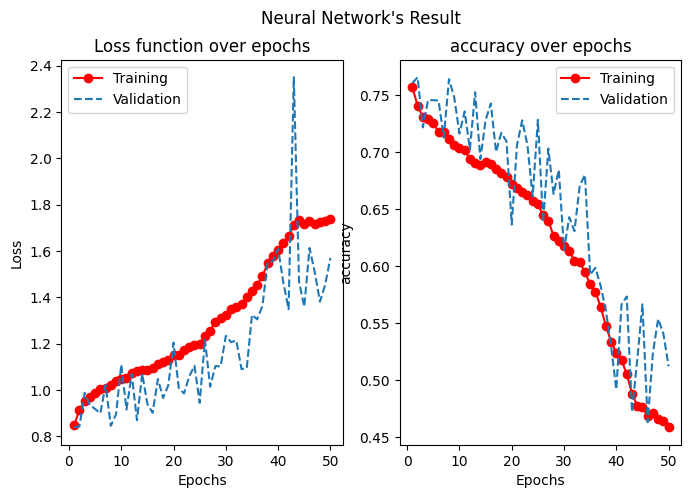

313/313 [==============================] - 2s 6ms/step - loss: 1.5400 - accuracy: 0.5112


[1.5399712324142456, 0.5112000107765198]

In [30]:
plot_result(history, "accuracy")
md.evaluate(X_test, y_test)

Hemos tenido muy buenos resultados, sin embargo, más adelante veremos más técnicas que podemos utilizar con el objetivo de optimizar este resultado.
